In [1]:
from collections import defaultdict

from workflow.gunc.rank_contigs_by_contamination import GuncRankContigsByContamination
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


ModuleNotFoundError: No module named 'workflow'

In [2]:
DF_RANKING = GuncRankContigsByContamination().output().read_cached()
DF_RANKING.head()

,gid,contig,length,gc,correct_genes,total_genes,pct_correct,gc_delta,order
0,GCA_000143435.1,CP002036.1,20426,38.690884,0,26,0.000000,5.793160,0
1,GCA_000143435.1,CP002035.1,44581,39.380005,0,50,0.000000,6.482280,1
2,GCA_000143435.1,CP002037.1,242962,31.996773,202,246,82.113821,0.900951,2
3,GCA_000143435.1,CP002034.1,1828169,32.897724,1626,1788,90.939597,0.000000,3
4,GCA_000153745.1,DS022288.2,65290,41.966611,0,61,0.000000,5.338278,0


<AxesSubplot:>

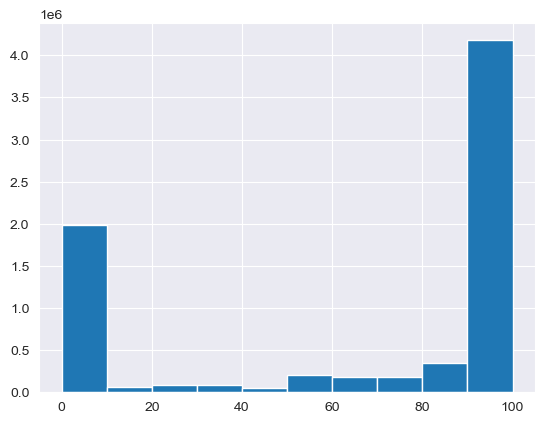

In [10]:
DF_RANKING['pct_correct'].hist()

In [24]:
DF_RANKING[DF_RANKING['gid'] == 'GCA_018662785.1']

,gid,contig,length,gc,correct_genes,total_genes,pct_correct,gc_delta,order
2176323,GCA_018662785.1,JABJFK010000078.1,2000,28.300000,0,2,0.00000,1.063922,0
2176324,GCA_018662785.1,JABJFK010000268.1,2001,27.686157,0,2,0.00000,1.677765,1
2176325,GCA_018662785.1,JABJFK010000087.1,2001,30.684658,0,2,0.00000,1.320736,2
2176326,GCA_018662785.1,JABJFK010000218.1,2031,29.345150,0,2,0.00000,0.018771,3
2176327,GCA_018662785.1,JABJFK010000082.1,2039,31.927415,0,3,0.00000,2.563494,4
...,...,...,...,...,...,...,...,...,...
2176663,GCA_018662785.1,JABJFK010000012.1,22072,32.656760,0,24,0.00000,3.292838,340
2176664,GCA_018662785.1,JABJFK010000231.1,27801,31.977267,0,28,0.00000,2.613345,341
2176665,GCA_018662785.1,JABJFK010000273.1,28276,33.017400,0,25,0.00000,3.653478,342
2176666,GCA_018662785.1,JABJFK010000035.1,33657,33.116439,0,28,0.00000,3.752518,343


In [3]:
def get_gid_to_rows():
    out = defaultdict(list)
    for row in tqdm(DF_RANKING.itertuples(), total=len(DF_RANKING)):
        out[row.gid].append({
            'contig': row.contig,
            'length': row.length,
            'pct_correct': row.pct_correct,
        })
    return out
D_GID_TO_ROWS = get_gid_to_rows()

100%|██████████| 7372027/7372027 [00:17<00:00, 431618.21it/s]


In [4]:
GIDS = sorted(set(DF_RANKING['gid'].unique()))

In [28]:
PCT_VALS = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50)

In [6]:
def get_distribution_of_pct_correct():
    out = list()

    for gid, rows in tqdm(D_GID_TO_ROWS.items()):
        df_rows = pd.DataFrame(rows)
        out.append({
            'gid': gid,
            'pct_max': df_rows['pct_correct'].max(),
        })

    return pd.DataFrame(out)
DF_DIST_PCT = get_distribution_of_pct_correct()

100%|██████████| 35723/35723 [00:28<00:00, 1244.45it/s]


,gid,pct_max
2467,GCA_002712565.1,66.666667
4886,GCA_009493725.1,84.375000
6610,GCA_014361295.1,80.611621
7251,GCA_016125005.1,84.000000
7456,GCA_016301945.1,80.000000
7530,GCA_016712675.1,65.343767
7531,GCA_016712825.1,82.692308
8368,GCA_017608295.1,78.301887
9634,GCA_018662785.1,69.901720
9640,GCA_018663345.1,69.901720


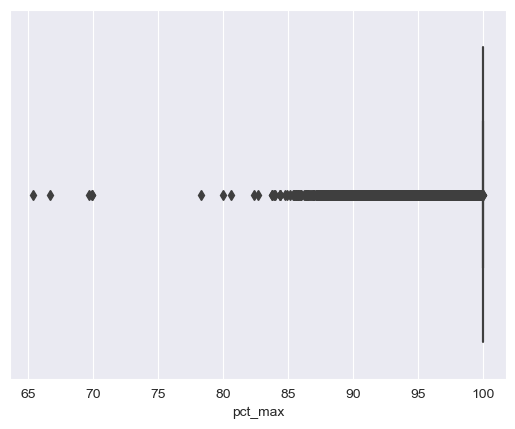

In [14]:
sns.boxplot(data=DF_DIST_PCT, x='pct_max')

DF_DIST_PCT[DF_DIST_PCT['pct_max'] < 85]

In [29]:
def remove_by_pct_correct():

    out = list()

    for gid, rows in tqdm(D_GID_TO_ROWS.items()):
        df_rows = pd.DataFrame(rows)
        genome_size = int(df_rows['length'].sum())

        for pct in PCT_VALS:
            nt_removed = int(df_rows[df_rows['pct_correct'] <= pct]['length'].sum())
            genome_size_at_pct = genome_size - nt_removed
            pct_removed = (nt_removed / genome_size) * 100

            out.append({
                'gid': gid,
                'pct': pct,
                'size': genome_size_at_pct,
                'pct_removed': pct_removed
            })


    return pd.DataFrame(out)

DF_REMOVE_BY_PCT = remove_by_pct_correct()
DF_REMOVE_BY_PCT.head()

100%|██████████| 35723/35723 [03:52<00:00, 153.40it/s]


,gid,pct,size,pct_removed
0,GCA_000143435.1,0,2071131,3.043202
1,GCA_000143435.1,1,2071131,3.043202
2,GCA_000143435.1,2,2071131,3.043202
3,GCA_000143435.1,3,2071131,3.043202
4,GCA_000143435.1,4,2071131,3.043202


<AxesSubplot:xlabel='pct', ylabel='pct_removed'>

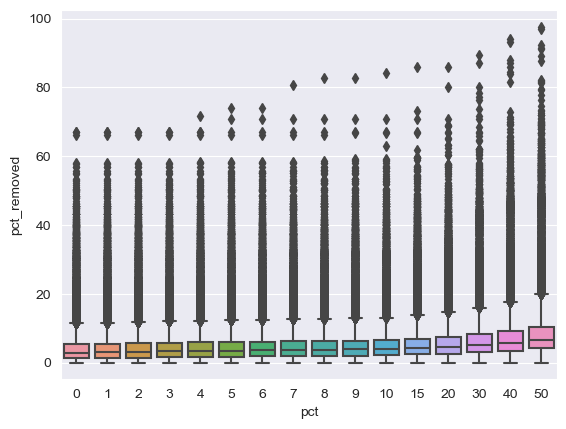

In [30]:
sns.boxplot(data=DF_REMOVE_BY_PCT, x='pct', y='pct_removed')

In [25]:
DF_REMOVE_BY_PCT[(DF_REMOVE_BY_PCT['pct'] == 1) & (DF_REMOVE_BY_PCT['pct_removed'] > 20)]

,gid,pct,size,pct_removed
16,GCA_000155005.1,1,5914511,22.041799
56,GCA_000172255.1,1,1147666,36.182562
896,GCA_000500955.1,1,895598,23.217631
936,GCA_000501195.1,1,959279,20.835826
992,GCA_000501475.1,1,969012,21.148083
...,...,...,...,...
257008,GCF_017912145.1,1,1091585,20.342729
257112,GCF_017912405.1,1,1013981,20.156902
269216,GCF_900088665.2,1,1364200,20.622129
269632,GCF_900109145.1,1,4046440,25.020883


In [46]:
def remove_contigs_in_order():

    out = list()

    for gid, rows in tqdm(D_GID_TO_ROWS.items()):
        df_rows = pd.DataFrame(rows)
        genome_size = int(df_rows['length'].sum())

        if gid == 'GCA_000431935.1':
            print()

        for pct in PCT_VALS:

            contigs_removed = set()
            nt_removed = 0

            for row in df_rows.itertuples():
                if row.pct_correct >= 75:
                    break

                new_pct_removed = 100 * (row.length + nt_removed) / genome_size

                if new_pct_removed > pct:
                    break

                nt_removed += row.length
                contigs_removed.add(row.contig)

            out.append({
                'gid': gid,
                'pct': pct,
                'pct_removed': 100 * nt_removed / genome_size
            })

    return pd.DataFrame(out)

DF_IN_ORDER = remove_contigs_in_order()

  0%|          | 125/35723 [00:00<01:52, 317.73it/s]

100%|██████████| 35723/35723 [01:53<00:00, 315.52it/s]


<AxesSubplot:xlabel='pct', ylabel='pct_removed'>

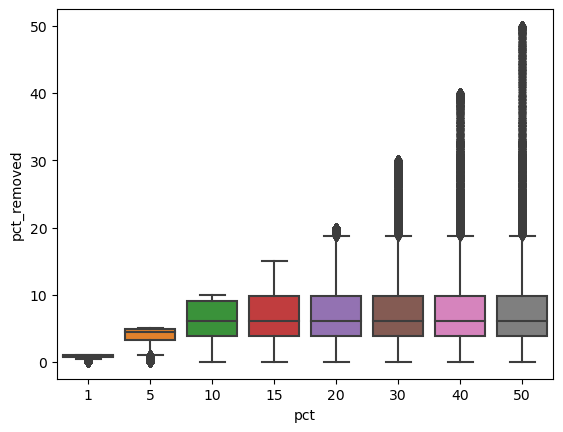

In [45]:
sns.boxplot(data=DF_IN_ORDER, x='pct', y='pct_removed')

<AxesSubplot:xlabel='pct', ylabel='pct_removed'>

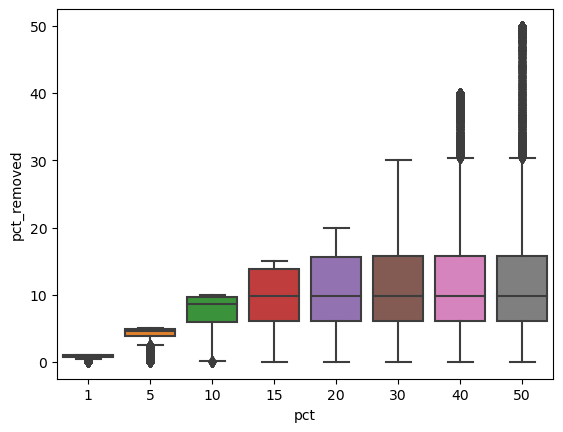

In [47]:
sns.boxplot(data=DF_IN_ORDER, x='pct', y='pct_removed')